Based on https://github.com/James-Jagielski/7-bit-D-A-converter-MP4-MADVLSI/blob/main/schematics/simulations/plot_dac_mc.ipynb with permission of repo owners

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format
from matplotlib.ticker import FuncFormatter

In [196]:
n_bits = 4
nano = 1e-9
results_dir = "./dac"

2475


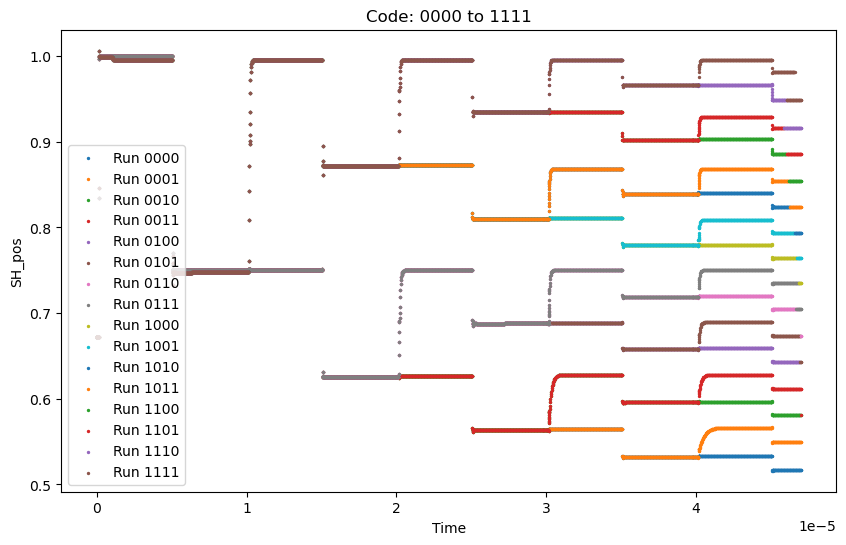

<Figure size 640x480 with 0 Axes>

In [197]:
df = []
mc_simulations = []
for filename in os.listdir(results_dir):
    A_values = []
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    step = int(len(df)/(2**n_bits)-1)
    print(step)
    # print(df[df["time"]==2.4e-5])
    plt.figure(figsize = (10, 6))
    plt.xlabel("Time")
    plt.ylabel("SH_pos")
    for i in range(2**n_bits):
        dfsim = (df[i*step:(i+1)*step])
        A_values.append(np.array(dfsim["v(sh_pos)"][int(step*(i+0.954))])) #["v(sh_pos)"]int(0.954*step)
        plt.scatter(np.array(dfsim["time"]), np.array(dfsim["v(sh_pos)"]), 
                    s = 2, label = f"Run {bin(i)[2:].zfill(n_bits)}")
    plt.legend(loc = "lower left")
    plt.title("Code: 0000 to 1111")
    plt.figure()
    mc_simulations.append(A_values)
    

mean endpoint diff: 0.46224998799999995 V
ideal step 0.028890624249999997 V
[array([-0.42722193,  0.62609993,  0.0795269 ,  0.07654545,  0.044821  ,
        0.0623244 ,  0.03963247,  0.04049929, -0.01763012,  0.0971721 ,
       -0.02089326,  0.19142009, -0.09590988,  0.29336942,  0.01024415])]
dnl length: 15
max overall dnl 0.626099927556949
INL [0.0]
max overall inl 0.0


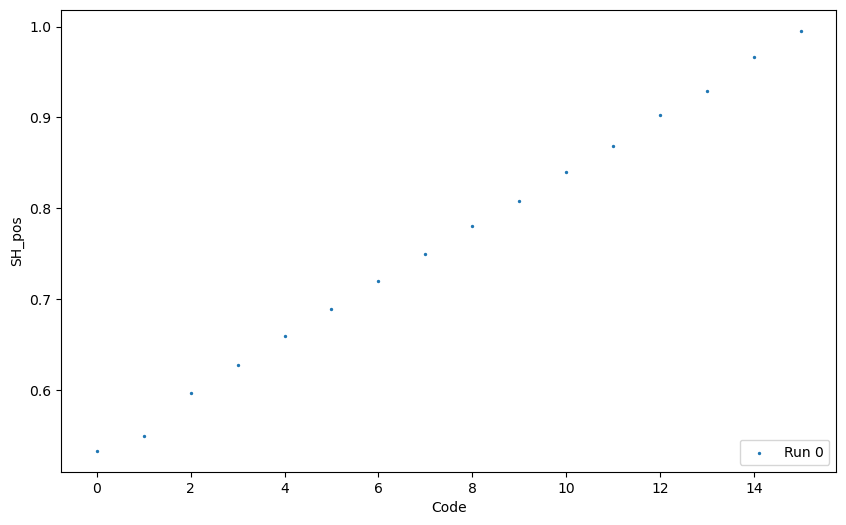

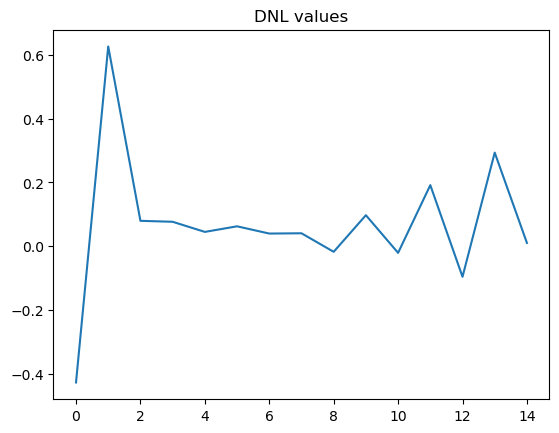

In [198]:
endpoint_diff = []
dnls = []
code = range(2**n_bits)
inl = []

plt.figure(figsize = (10, 6))

for i, sim in enumerate(mc_simulations):
    endpoint_diff.append(sim[2**n_bits - 1] - sim[0])
    plt.scatter(np.array(code), np.array(mc_simulations), s = 2, label = f"Run {i}")

print("mean endpoint diff:", np.mean(endpoint_diff),"V")
ideal_step_size = np.mean(endpoint_diff) / (2 ** n_bits)
print("ideal step", ideal_step_size, "V")

for sim in mc_simulations:
    dnl = np.subtract(np.divide(
                      np.subtract(sim[1:],sim[:-1]),
                      ideal_step_size),1)
    inl.append(np.sum(inl))
    dnls.append(dnl)

print(dnls)
plt.legend(loc = "lower right")
plt.xlabel("Code")
plt.ylabel("SH_pos")

plt.figure()
plt.plot(range(len(dnl)), dnl)
print("dnl length:",len(dnl))
plt.title("DNL values")
print("max overall dnl",max(dnl,key=abs))
print("INL" , inl)
print("max overall inl", max(inl))


0.51643191


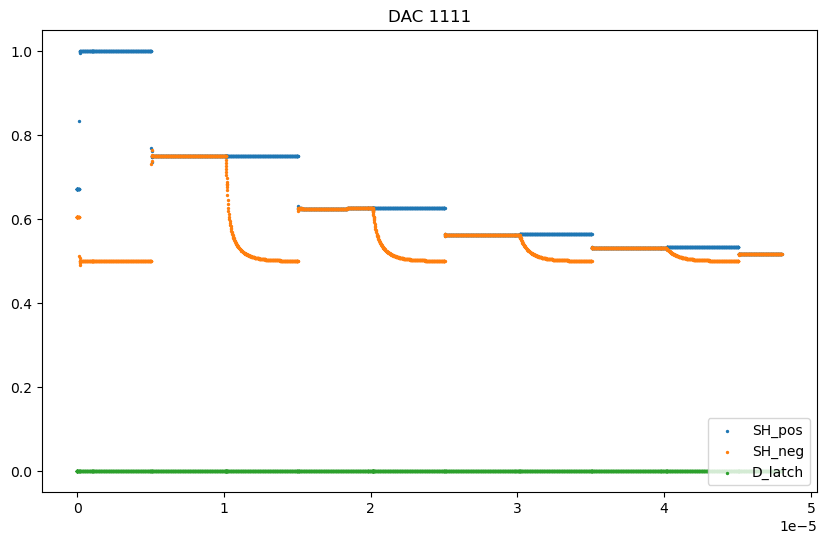

<Figure size 640x480 with 0 Axes>

In [114]:
dfsim = df[:step]
plt.figure(figsize = (10, 6))
plt.scatter(np.array(dfsim["time"]), np.array(dfsim["v(sh_pos)"]), s = 2, label = "SH_pos")
plt.scatter(np.array(dfsim["time"]), np.array(dfsim["v(SH_neg)"]), s = 2, label = "SH_neg")
plt.scatter(np.array(dfsim["time"]), np.array(dfsim["v(D_latch)"]), s = 2, label = "D_latch")
plt.legend(loc = "lower right")
plt.title("DAC 1111")
plt.figure()
len(dfsim)
print(dfsim["v(sh_pos)"][int(0.954*step)])
# print(len(dfsim[dfsim["time"]>=4.6e-5]))

In [193]:
mc_simulations = []
endpoint_diff = []
for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print(df.head(3))
    #print(df)
    # df["code"] = df["v(b0)"] * 0 # init column to all 0s
    # for bit in range(n_bits):
    #     # df["code"] = df["code"] + (df[f"v{bit}"] > .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
    #     df["code"] = df["code"] + (df[f"v(b{bit})"] > .5*1.8) * 2 ** (n_bits - bit - 1) #WHAT DOES THIS DO
    #     df.drop(f"v(b{bit})", axis = "columns", inplace = True)
    df["code"] = range(128)
    df.rename({"i(VI_out)": "Iout"}, axis = "columns", inplace = True)
    # print(df.head(10))
    mc_simulations.append(df)
    endpoint_diff.append(df["Iout"][2**n_bits - 1] - df["Iout"][0])
    print("mean endpoint diff:", np.mean(endpoint_diff))

ideal_step_size = np.mean(endpoint_diff) / (2 ** n_bits)
print(ideal_step_size)
tdf = pd.concat(mc_simulations)
plt.figure(figsize = (10, 6))
plt.xlabel("Code")
plt.ylabel("Iout")

#z = np.polyfit(tdf["code"], tdf["Iout"], 1)
z = [ideal_step_size,0]
print(z)
p = np.poly1d(z)

errors = np.subtract(p(tdf["code"]),tdf["Iout"])

print("max allowable error", np.mean( np.subtract( p(range(1,128)) ,p(range(0,127)) ) )/2 )
print("max error",np.max(errors))
print("variance of error",np.max(errors))

dnl  = []
dnl_multi = []
inl = []
for df_simulation in mc_simulations:
    sorted = df_simulation.sort_values("code")
    current =   np.subtract(np.divide(
                    np.subtract(
                         list(sorted["Iout"])[1:],list(sorted["Iout"])[:-1]
                    ),ideal_step_size),1)
    current_inl = np.sum(current)
    # print(current_inl)
    cc = list(current) #list(np.vstack((current,dnl)).T)
    #print(len(cc))
    dnl_multi.append(cc)
    inl.append(current_inl)
    dnl.append(max(current, key=abs))
    for line in cc:
        dnl.append(line)#dnl.append(float(max(line,key=abs)))
    print(cc)

# plt.plot(range(128),p(range(128)),"k--", label = "trendline", linewidth = .5)

for i, df_simulation in enumerate(mc_simulations):
    # plt.plot(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure()
plt.plot(range(len(dnl)), dnl)
print("dnl length:",len(dnl))
plt.title("DNL values")
print("max overall dnl",max(dnl,key=abs)) 
print("loc of max value",dnl.index(max(dnl,key=abs)))
print("INL" , inl)
print("max overall inl", max(inl))
plt.ylabel("lsbs of error")

ValueError: Length of values (128) does not match length of index (39622)

7.980901657651406e-08
[7.980901657651406e-08, 0]
max allowable error 3.990450828825703e-08
max error 9.523932064258955e-09
variance of error 9.523932064258955e-09
-3.810958476423451
5.81095847642346
max overall dnl 2.6415694498499267
loc of max value 127
INL [-3.810958476423451, 5.81095847642346]
max overall inl 5.81095847642346


Text(0, 0.5, 'lsbs of error')

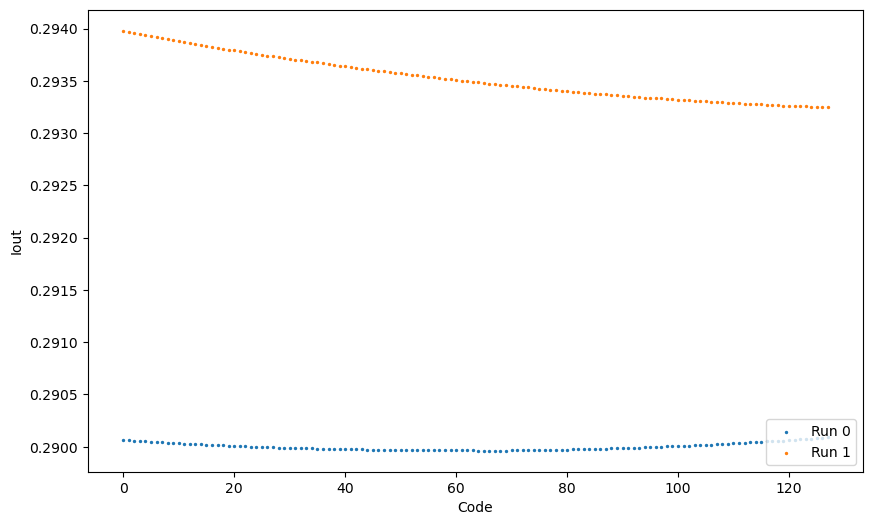

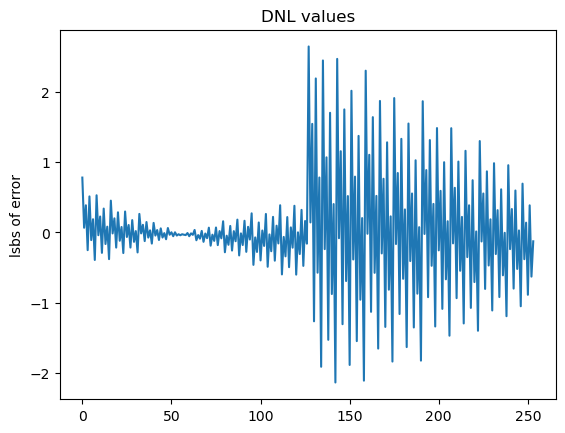

In [91]:
results_dir = "./Vin"
mc_simulations = []
endpoint_diff = []
for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print(df.head(3))
    #print(df)
    # df["code"] = df["v(b0)"] * 0 # init column to all 0s
    # for bit in range(n_bits):
    #     # df["code"] = df["code"] + (df[f"v{bit}"] > .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
    #     df["code"] = df["code"] + (df[f"v(b{bit})"] > .5*1.8) * 2 ** (n_bits - bit - 1) #WHAT DOES THIS DO
    #     df.drop(f"v(b{bit})", axis = "columns", inplace = True)
    df["code"] = range(128)
    df.rename({"i(VI_out)": "Iout"}, axis = "columns", inplace = True)
    # print(df.head(10))
    mc_simulations.append(df)
    endpoint_diff.append(df["Iout"][127]-df["Iout"][0])

ideal_step_size = np.mean(endpoint_diff) / (2 ** n_bits)
print(ideal_step_size)
tdf = pd.concat(mc_simulations)
plt.figure(figsize = (10, 6))
plt.xlabel("Code")
plt.ylabel("Iout")

#z = np.polyfit(tdf["code"], tdf["Iout"], 1)
z = [ideal_step_size,0]
print(z)
p = np.poly1d(z)

errors = np.subtract(p(tdf["code"]),tdf["Iout"])

print("max allowable error", np.mean( np.subtract( p(range(1,128)) ,p(range(0,127)) ) )/2 )
print("max error",np.max(errors))
print("variance of error",np.max(errors))

dnl  = []
dnl_multi = []
inl = []
for df_simulation in mc_simulations:
    sorted = df_simulation.sort_values("code")
    current =   np.subtract(np.divide(
                    np.subtract(
                         list(sorted["Iout"])[1:],list(sorted["Iout"])[:-1]
                    ),ideal_step_size),1)
    current_inl = np.sum(current)
    print(current_inl)
    cc = list(current) #list(np.vstack((current,dnl)).T)
    #print(len(cc))
    dnl_multi.append(cc)
    inl.append(current_inl)
    for line in cc:
        dnl.append(line)#dnl.append(float(max(line,key=abs)))
    #print(dnl)

# plt.plot(range(128),p(range(128)),"k--", label = "trendline", linewidth = .5)

for i, df_simulation in enumerate(mc_simulations):
    # plt.plot(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["v(Vin)"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure()
plt.plot(range(len(dnl)), dnl)
plt.title("DNL values")
print("max overall dnl",max(dnl,key=abs)) 
print("loc of max value",dnl.index(max(dnl,key=abs)))
print("INL" , inl)
print("max overall inl", max(inl))
plt.ylabel("lsbs of error")